## Inspect Prediction Results

In this notebook, we loop over all classification task predictions to detect where and how PrivBERT and other models differ in their predictions.

In [1]:
import json
import os
from collections import Counter
from itertools import product

import matplotlib
import pandas as pd
from plotnine import (
    aes,
    element_blank,
    element_text,
    facet_wrap,
    geom_col,
    ggplot,
    labs,
    scale_fill_brewer,
    theme,
    theme_bw,
)
from tqdm import tqdm

%matplotlib inline
matplotlib.rc("text", usetex=True)

In [2]:
# declare global variables
MODELS = {
    "bert_base_uncased": "BERT",
    "roberta_base": "RoBERTa",
    "nlpaueb_legal_bert_base_uncased": "Legal-BERT",
    "saibo_legal_roberta_base": "Legal-RoBERTa",
    "mukund_privbert": "PrivBERT",
}

TASKS = {
    "opp_115": "\\textbf{OPP-115}",
    "policy_detection": "\\textbf{Policy-Detection}",
    "policy_ie_a": "\\textbf{PolicyIE-A}",
    "privacy_qa": "\\textbf{PrivacyQA}",
}


RANDOM_SEED_ITERATIONS = 10

# collect all predictions in dictionary
predictions = {}
for model in MODELS.keys():
    predictions[model] = {}
    for task in TASKS.keys():
        predictions[model][task] = []
        for index in range(RANDOM_SEED_ITERATIONS):
            with open(
                os.path.join(
                    "..", "runs", model, task, f"seed_{index}", "predictions.json"
                ),
                "r",
            ) as input_file_stream:
                preds = json.load(input_file_stream)
                predictions[model][task].append(preds)

Now we perform comparisons of predictions on PrivBERT vs. all other models and aggregate results.

In [3]:
# create storage variables and priv_bert predictions
comparisons = {}
priv_bert = predictions["mukund_privbert"]

# loop across all models that are not PrivBERT
for model in tqdm(MODELS.keys()):
    if model != "mukund_privbert":
        other_model = predictions[model]
        comparisons[("mukund_privbert", model)] = {}

        # loop across relevant tasks
        for task in TASKS.keys():
            priv_bert_task = priv_bert[task]
            other_model_task = other_model[task]
            maybe_sort = sorted if task == "opp_115" else lambda x: x
            quadrant = []

            # loop across all seed combinations
            for seed_priv_bert, seed_other_model in product(
                range(RANDOM_SEED_ITERATIONS), range(RANDOM_SEED_ITERATIONS)
            ):
                predictions_priv_bert = priv_bert_task[seed_priv_bert]
                predictions_other_model = other_model_task[seed_other_model]
                quadrant_seed = []

                # loop across all examples per seed combination
                for prediction_priv_bert, prediction_other_model in zip(
                    predictions_priv_bert, predictions_other_model
                ):
                    # make sanity checks
                    assert prediction_priv_bert["id"] == prediction_other_model["id"]
                    assert (
                        prediction_priv_bert["gold_label"]
                        == prediction_other_model["gold_label"]
                    )

                    # get necessary booleans
                    priv_bert_correct = maybe_sort(
                        prediction_priv_bert["predicted_label"]
                    ) == maybe_sort(prediction_priv_bert["gold_label"])
                    other_model_correct = maybe_sort(
                        prediction_other_model["predicted_label"]
                    ) == maybe_sort(prediction_other_model["gold_label"])

                    # increment frequency counts
                    if priv_bert_correct and other_model_correct:
                        quadrant_seed.append(1)
                    elif priv_bert_correct and not other_model_correct:
                        quadrant_seed.append(2)
                    elif not priv_bert_correct and other_model_correct:
                        quadrant_seed.append(3)
                    else:
                        quadrant_seed.append(4)

                # collect quadrant_seed
                quadrant.append(quadrant_seed)

            # collect unique number of quadrant shifts
            comparisons[("mukund_privbert", model)][task] = dict(
                Counter(list(map(frozenset, (zip(*quadrant)))))
            )

100%|██████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.67s/it]


Now we compile results into a pandas dataframe.

In [4]:
# consolidate dataframe
df = (
    pd.DataFrame.from_dict(comparisons)
    .melt(var_name=["first_model", "second_model"], ignore_index=False)
    .reset_index()
    .rename(columns={"index": "task"})
)

# replace model and task names, plus order models
df["second_model"] = pd.Categorical(
    df["second_model"].replace(MODELS), list(MODELS.values())
)
df["task"] = df["task"].replace(TASKS)

# split counter dictionary into columns and normalize
hold = df["value"].apply(pd.Series)
df = pd.concat([df.drop("value", axis=1), hold.div(hold.sum(axis=1), axis=0)], axis=1)

# convert wide to long and fill NaN values
df = df.melt(id_vars=["task", "second_model", "first_model"])
df = df.fillna(0)

# convert set/tuple to string for better plotting
maybe_sum = lambda x: sum(x) if isinstance(x, tuple) else x  # noqa: E731
df["variable"] = df["variable"].apply(
    lambda x: "(%s)" % ", ".join([str(stuff) for stuff in x])
)
df["variable"] = pd.Categorical(
    df["variable"],
    list(
        reversed(
            sorted(
                df["variable"].unique().tolist(),
                key=lambda x: len(x) + maybe_sum(eval(x)),
            )
        )
    ),
)

# infer modified data types for plotting
df = df.infer_objects()

In [5]:
df

,task,second_model,first_model,variable,value
0,\textbf{OPP-115},BERT,mukund_privbert,(1),0.591105
1,\textbf{Policy-Detection},BERT,mukund_privbert,(1),0.805627
2,\textbf{PolicyIE-A},BERT,mukund_privbert,(1),0.670509
3,\textbf{PrivacyQA},BERT,mukund_privbert,(1),0.852003
4,\textbf{OPP-115},RoBERTa,mukund_privbert,(1),0.591105
...,...,...,...,...,...
139,\textbf{PrivacyQA},Legal-BERT,mukund_privbert,(3),0.000016
140,\textbf{OPP-115},Legal-RoBERTa,mukund_privbert,(3),0.000000
141,\textbf{Policy-Detection},Legal-RoBERTa,mukund_privbert,(3),0.000000
142,\textbf{PolicyIE-A},Legal-RoBERTa,mukund_privbert,(3),0.000000


Now we plot our results.

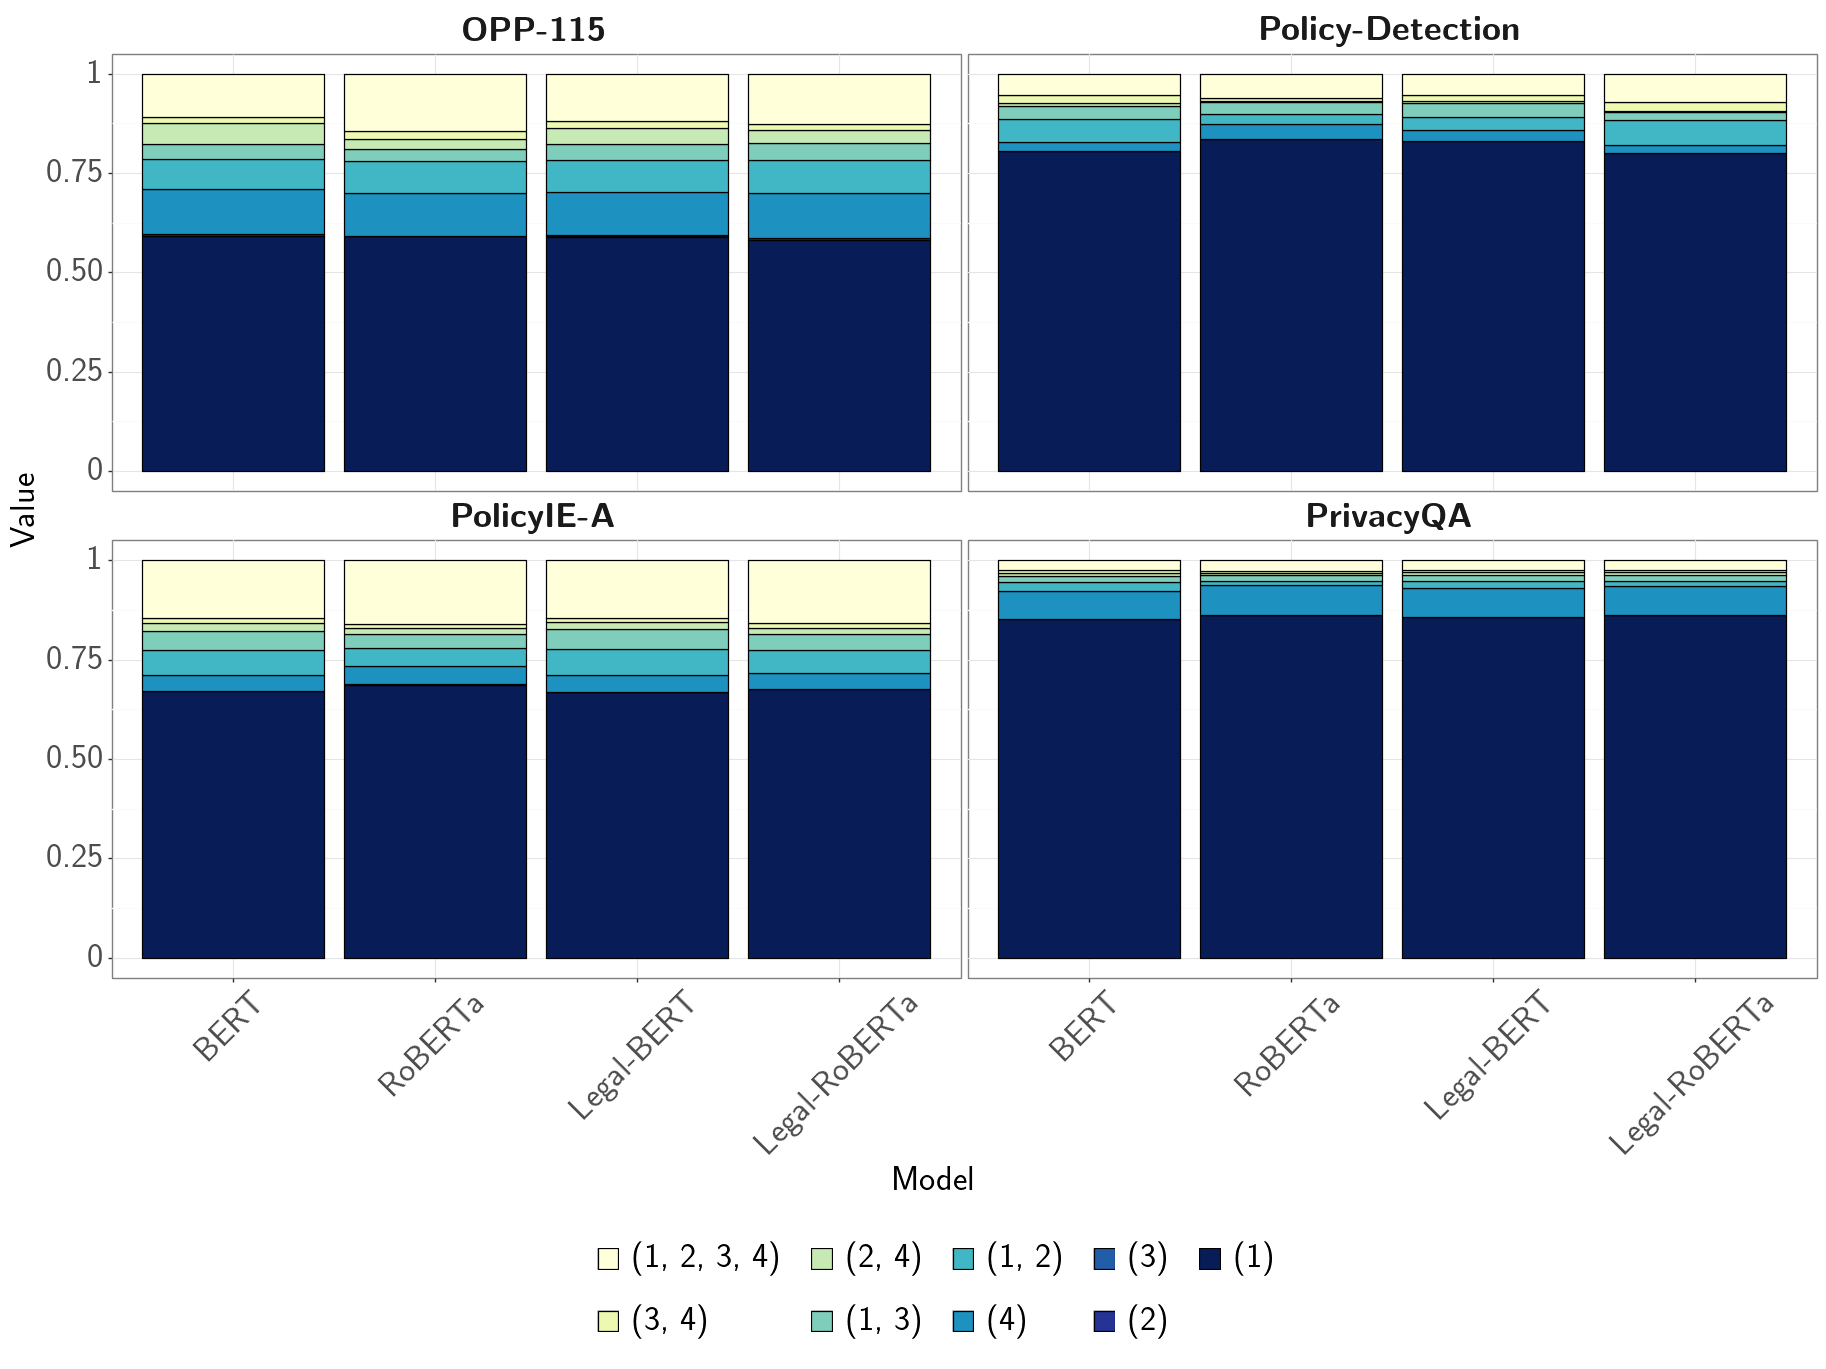

In [6]:
# plot ggplot object
(
    ggplot(df, aes(x="second_model", y="value", fill="variable"))
    + geom_col(color="black")
    + facet_wrap("task")
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45),
        figure_size=(22, 12),
        text=element_text(size=25),
        legend_text=element_text(margin={"l": 10}),
        legend_position=(0.5, -0.15),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_entry_spacing=20,
        strip_background=element_blank(),
    )
    + scale_fill_brewer("seq", 16)
    + labs(x="Model", y="Value")
).draw();